In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import modules.data_visualization_utils as dau
from importlib import reload

# my_computer_fpath = "C:\\Users\\dfber\\OneDrive - Mass General Brigham\\Epidural project\\Data\\"
my_computer_fpath = "C:\\Users\\User\\OneDrive - Mass General Brigham\\Epidural project\\Data\\"

In [9]:
df = pd.read_csv(my_computer_fpath + 'processed_and_imputed_merlin_data.csv') 

In [10]:
# Assume 'df' is your DataFrame with columns:
#   - Outcome: 'failed_catheter'
#   - Group ID: 'unique_pt_id' (vs 'anes_procedure_encounter_id_2273')
# Remove the group column from the features.
# Remove the outcome columns from the features.
X = df.drop(columns=["unique_pt_id", "anes_procedure_encounter_id_2273", "failed_catheter", "has_subsequent_neuraxial_catheter", "has_subsequent_spinal", "has_subsequent_airway", "placement_to_delivery_hours", "rom_thru_delivery_hours"])
y = df["failed_catheter"]
groups = df["unique_pt_id"]

c:\Users\User\Documents\GitHub\Epidural-Analysis\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-25 16:08:40,060] A new study created in memory with name: no-name-d4f35870-d050-484f-92ca-7d76f4e5b7cd
[I 2025-02-25 16:09:59,154] Trial 0 finished with value: 0.676605039454574 and parameters: {'k': 55, 'classifier': 'logistic', 'C': 6.612846863163532, 'penalty': 'l1'}. Best is trial 0 with value: 0.676605039454574.
[I 2025-02-25 16:10:02,719] Trial 1 finished with value: 0.6743331270693521 and parameters: {'k': 48, 'classifier': 'logistic', 'C': 0.024664967176430404, 'penalty': 'l2'}. Best is trial 0 with value: 0.676605039454574.
c:\Users\User\Documents\GitHub\Epidural-Analysis\.conda\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows

Best trial:
  Best AUC: 0.689379130562573
    k: 63
    classifier: random_forest
    rf_n_estimators: 300
    rf_max_depth: 10

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     14157
           1       0.00      0.00      0.00       898

    accuracy                           0.94     15055
   macro avg       0.47      0.50      0.48     15055
weighted avg       0.88      0.94      0.91     15055

Confusion Matrix:
[[14157     0]
 [  898     0]]
Test AUC: 0.7034205024688929


c:\Users\User\Documents\GitHub\Epidural-Analysis\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Documents\GitHub\Epidural-Analysis\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\Documents\GitHub\Epidural-Analysis\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

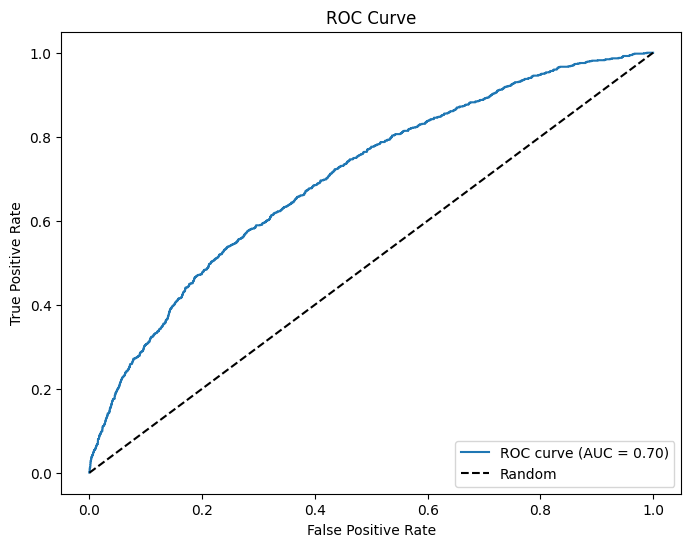

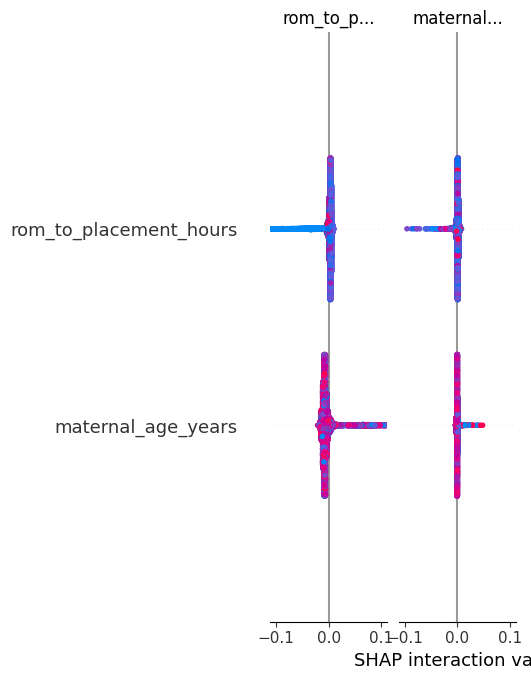

In [13]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

# Define a preprocessor to scale numeric features and one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Group-based Train/Test Split: ensure that data from a given patient is only in train or test.
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

def objective(trial):
    # Optimize the number of top features to select.
    # (Here we use the original number of features as an approximation.)
    k = trial.suggest_int("k", 1, X_train.shape[1])
    
    # Choose classifier type.
    classifier_name = trial.suggest_categorical("classifier", ["logistic", "random_forest", "xgboost"])
    
    if classifier_name == "logistic":
        C = trial.suggest_float("C", 1e-3, 1e2, log=True)
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
        model = LogisticRegression(solver="liblinear", C=C, penalty=penalty, random_state=42)
        
    elif classifier_name == "random_forest":
        n_estimators = trial.suggest_int("rf_n_estimators", 50, 300)
        max_depth = trial.suggest_int("rf_max_depth", 3, 20)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
    elif classifier_name == "xgboost":
        n_estimators = trial.suggest_int("xgb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("xgb_max_depth", 3, 20)
        learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3, log=True)
        model = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth, 
            learning_rate=learning_rate, 
            random_state=42, 
            use_label_encoder=False, 
            eval_metric="logloss"
        )
        
    # Build a pipeline with preprocessing, feature selection, and the classifier.
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("select", SelectKBest(score_func=f_classif, k=k)),
        ("clf", model)
    ])
    
    # Use 5-fold cross-validation (ROC AUC) on the training set.
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="roc_auc").mean()
    return score

# Run an Optuna study to maximize ROC AUC.
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f"  Best AUC: {trial.value}")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Reconstruct the best pipeline using the optimal parameters.
best_classifier = trial.params["classifier"]

if best_classifier == "logistic":
    best_model = LogisticRegression(
        solver="liblinear",
        C=trial.params["C"],
        penalty=trial.params["penalty"],
        random_state=42
    )
elif best_classifier == "random_forest":
    best_model = RandomForestClassifier(
        n_estimators=trial.params["rf_n_estimators"],
        max_depth=trial.params["rf_max_depth"],
        random_state=42
    )
elif best_classifier == "xgboost":
    best_model = XGBClassifier(
        n_estimators=trial.params["xgb_n_estimators"],
        max_depth=trial.params["xgb_max_depth"],
        learning_rate=trial.params["xgb_learning_rate"],
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("select", SelectKBest(score_func=f_classif, k=trial.params["k"])),
    ("clf", best_model)
])
final_pipeline.fit(X_train, y_train)

# Evaluate the final model on the test set.
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
test_auc = roc_auc_score(y_test, y_proba)
print("Test AUC:", test_auc)

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# -------------------------------
# SHAP Analysis for Model Interpretability
# -------------------------------
# Get feature names after preprocessing.
# (Requires scikit-learn 1.0+)
feature_names_num = numeric_cols
feature_names_cat = final_pipeline.named_steps["preprocessor"].transformers_[1][1]\
                    .get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([feature_names_num, feature_names_cat])

# Retrieve indices of the selected features from SelectKBest.
selected_mask = final_pipeline.named_steps["select"].get_support()
selected_feature_names = all_feature_names[selected_mask]

# Transform training and test data for SHAP analysis.
X_train_preprocessed = final_pipeline.named_steps["preprocessor"].transform(X_train)
X_train_transformed = final_pipeline.named_steps["select"].transform(X_train_preprocessed)

X_test_preprocessed = final_pipeline.named_steps["preprocessor"].transform(X_test)
X_test_transformed = final_pipeline.named_steps["select"].transform(X_test_preprocessed)

# Choose the appropriate SHAP explainer based on the classifier.
if best_classifier == "logistic":
    explainer = shap.LinearExplainer(
        final_pipeline.named_steps["clf"], 
        X_train_transformed,
        feature_perturbation="interventional"
    )
else:
    explainer = shap.TreeExplainer(final_pipeline.named_steps["clf"])

# Calculate SHAP values on the test set.
shap_values = explainer.shap_values(X_test_transformed)

# Plot the SHAP summary plot using the selected feature names.
shap.summary_plot(shap_values, X_test_transformed, feature_names=selected_feature_names)
